In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torchtext
from torchtext.data import Iterator, BucketIterator
from torchvision import transforms, utils
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score as f1
import pandas as pd
import seaborn as sns

In [2]:
batch_size = 300
num_folds = 5

def split_text(text):
    return text.split(' ')

def prepare_sequences():
    tokenizer = split_text # the function above is the function we will be using to tokenize the text
    TEXT = torchtext.data.ReversibleField(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = torchtext.data.Field(sequential=False, use_vocab=False) # sequential and use_vocab=False since no text (binary)
    QID = torchtext.data.Field(sequential=False, use_vocab=False)
    
    train_datafields = [("question_text", TEXT), ("target", LABEL)]
    fold_names = ['train_fold{}.csv'.format(i) for i in range(1,num_folds+1)]
    train_folds = []
    for fold in fold_names:
        train_folds.append(torchtext.data.TabularDataset( 
                # If we had a validation set as well, we would add an additional .splits(...)
                path=fold, # the root directory where the data lies
                format='csv',
                # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                skip_header=True, 
                fields=train_datafields
                )
            )
    test_datafields = [('qid', QID),("question_text", TEXT)]
    test = torchtext.data.TabularDataset( 
                    path='test.csv',
                    format="csv",
                    skip_header=True,
                    fields=test_datafields
                    )
    return TEXT, LABEL, train_folds, test

TEXT, LABEL, train, test = prepare_sequences()
vec = torchtext.vocab.Vectors('master_v2.txt')
TEXT.build_vocab(*train,test, vectors=vec)

emb_vecs = TEXT.vocab.vectors
for i in range(len(emb_vecs)):
    if len(emb_vecs[i, : ].nonzero()) == 0:
        # std = 0.05 is based on the norm of average GloVE 100-dim word vectors
        torch.nn.init.normal_(emb_vecs[i], mean=0, std=0.05)
       
train_fold_loader = []
for fold in train:
    train_fold_loader.append(BucketIterator(
         fold, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         shuffle = True,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )
    )
test_loader = BucketIterator(
         test, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )

In [3]:
def validation(loader, test_set, predictions):
    accuracy = 0
    num_batches = 0
    act = np.array([])
    pred = np.array([])
    with torch.no_grad():
        for batch in loader:
            gpu = batch.question_text.to(device).long()
            preds = atn_lstm(gpu)
            target = batch.target.numpy()
            preds = preds.cpu().detach().numpy()
            preds = preds >= 0.5
            preds = preds.flatten()
            total_correct = sum(target == preds)

            act = np.concatenate((act, target))
            pred = np.concatenate((pred, preds))

            accuracy += total_correct
            num_batches += 1
            torch.cuda.empty_cache()
            del gpu, target, preds
        
        count = 0
        for batch in test_set:
            qid = batch.qid
            question = batch.question_text.to(device).long()
            preds = atn_lstm(question)
            preds = preds.cpu().detach().numpy()
            for idx, ID in enumerate(qid):
                predictions[ID.item()].append(preds[idx])
            torch.cuda.empty_cache()
            del qid, question, preds
            count+=1
    
    acc = accuracy / (num_batches * batch_size)
    print('Accuracy ->',acc)
    formula1 = f1(act, pred)
    print('f1 ->',formula1)
    tn,fp,fn,tp = cm(act, pred).ravel()
    print('True positives -> {}\nFalse positives -> {}\nTrue negatives -> {}\nFalse negatives -> {}\n'.format(tp,fp,tn,fn))
    return acc, formula1

def plot():
    plt.scatter([i for i in range(len(accuracy_fold))], f1_fold, label = 'F1 Training set')
    a = 0
    for r in f1_fold:
        a += r
    a /= len(f1_fold)
    plt.plot([i for i in range(len(accuracy_fold))], [a for i in range(len(accuracy_fold))], label = 'Avg fold f1 = {0:.3f}'.format(float(a)))
    plt.legend()
    plt.title('5 Fold Cross-validation F1 score Attention bilstm')
    plt.xlabel('Fold held out')
    plt.ylabel('F1 Score')
    plt.show()

def train_model(batch):
    atn_lstm.zero_grad()
    optimizer.zero_grad()
    loss = 0
    
    gpu = batch.question_text.to(device).long()
    target = batch.target.to(device).to(device).float()

    predicted = atn_lstm(gpu).view(-1)
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()
    return loss.item()

In [4]:
class Attention(nn.Module):
    def __init__(self, batch_size, size):
        super(Attention, self).__init__()
        self.word_weight = nn.Linear(size, size)
        self.tanh = nn.Tanh()
        self.context_weight = nn.Linear(size, 1, bias = False)
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, inpt):
        inpt = inpt.permute(1,0,2)
        a = self.word_weight(inpt)
        a = self.tanh(a)
        a = self.context_weight(a)
        a = self.tanh(a)
        a = self.softmax(a)
        inpt = inpt * a
        return torch.sum(inpt, 1)

In [5]:
class attn_lstm(nn.Module): 
    def __init__(self, 
                 input_size, #size of in vector
                 hidden_size,
                 num_layers,
                 dropout
                 ):
        super(attn_lstm, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.emb = nn.Embedding(len(TEXT.vocab), self.input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        
        self.emb_dropout = nn.Dropout2d(dropout)
        self.lstm = nn.LSTM(self.input_size, 
                            self.hidden_size, 
                            num_layers = self.num_layers,
                            dropout = self.dropout,
                            bidirectional = True)
        self.attention = Attention(batch_size, self.hidden_size*2)
        self.relu = nn.LeakyReLU()
        self.layer = nn.Linear(self.hidden_size*2, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt): 

        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt,_ = self.lstm(inpt)
        inpt = self.attention(inpt)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt

  0%|          | 0/5 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++
Fold -> 0
	Epoch 1/5	AVG loss: 0.12198299454283461	Total loss:424.9887529872358
	Epoch 2/5	AVG loss: 0.09922721403748241	Total loss:345.70761370658875
	Epoch 3/5	AVG loss: 0.08478810166379802	Total loss:295.4017461966723
	Epoch 4/5	AVG loss: 0.07160279457911797	Total loss:249.46413631364703
	Epoch 5/5	AVG loss: 0.05991197656145069	Total loss:208.7333263400942
Accuracy -> 0.9536548029085342
f1 -> 0.6232546490514057


 20%|██        | 1/5 [38:23<2:33:33, 2303.25s/it]

True positives -> 9954
False positives -> 5826
True negatives -> 239236
False negatives -> 6208

++++++++++++++++++++++++++++++++++++++++
Fold -> 1
	Epoch 1/5	AVG loss: 0.1217483919515915	Total loss:424.17139755934477
	Epoch 2/5	AVG loss: 0.10266208109990121	Total loss:357.67469055205584
	Epoch 3/5	AVG loss: 0.08989699253166601	Total loss:313.2011219803244
	Epoch 4/5	AVG loss: 0.0775248905548657	Total loss:270.09671869315207
	Epoch 5/5	AVG loss: 0.06565682742590712	Total loss:228.74838675186038
Accuracy -> 0.955878300803674
f1 -> 0.6374829867375684


 40%|████      | 2/5 [1:18:30<1:56:43, 2334.39s/it]

True positives -> 10070
False positives -> 5361
True negatives -> 239701
False negatives -> 6092

++++++++++++++++++++++++++++++++++++++++
Fold -> 2
	Epoch 1/5	AVG loss: 0.12000328905444195	Total loss:418.09145906567574
	Epoch 2/5	AVG loss: 0.0983383713555271	Total loss:342.6108858026564
	Epoch 3/5	AVG loss: 0.08411993869782418	Total loss:293.07386642321944
	Epoch 4/5	AVG loss: 0.07130476207943927	Total loss:248.4257910847664
	Epoch 5/5	AVG loss: 0.05977208935548728	Total loss:208.24595931451768
Accuracy -> 0.954921546115576
f1 -> 0.6265198659645763


 60%|██████    | 3/5 [1:58:38<1:18:33, 2356.53s/it]

True positives -> 9816
False positives -> 5357
True negatives -> 239705
False negatives -> 6346

++++++++++++++++++++++++++++++++++++++++
Fold -> 3
	Epoch 1/5	AVG loss: 0.1214266003052844	Total loss:423.0502754636109
	Epoch 2/5	AVG loss: 0.10107926702411282	Total loss:352.1601663120091
	Epoch 3/5	AVG loss: 0.08927700995338222	Total loss:311.0411026775837
	Epoch 4/5	AVG loss: 0.07836479554113202	Total loss:273.02294766530395
	Epoch 5/5	AVG loss: 0.0682673127926142	Total loss:237.84331776946783
Accuracy -> 0.9556946039035591
f1 -> 0.6142804440419894


 80%|████████  | 4/5 [2:38:45<39:31, 2371.55s/it]  

True positives -> 9158
False positives -> 4497
True negatives -> 240565
False negatives -> 7004

++++++++++++++++++++++++++++++++++++++++
Fold -> 4
	Epoch 1/5	AVG loss: 0.12051150378857736	Total loss:419.8620791994035
	Epoch 2/5	AVG loss: 0.1021690605396467	Total loss:355.95700692012906
	Epoch 3/5	AVG loss: 0.08956518489600135	Total loss:312.0451041776687
	Epoch 4/5	AVG loss: 0.07734045134237127	Total loss:269.45413247682154
	Epoch 5/5	AVG loss: 0.06622687601013885	Total loss:230.73443601932377
Accuracy -> 0.9555951014159969
f1 -> 0.6186774289589467


100%|██████████| 5/5 [3:18:54<00:00, 2382.89s/it]

True positives -> 9351
False positives -> 4716
True negatives -> 240346
False negatives -> 6811



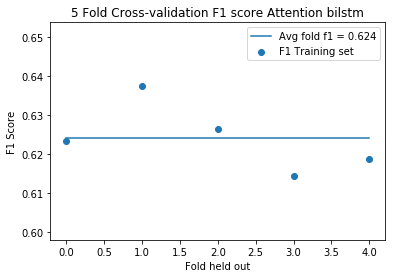

In [6]:
#batch_size for training
verbose = 100

#Model parameters
input_size = 300
hidden_dim = 300
num_layers = 2
dropout = 0.1

epoch = 5

#Evaluation metrics for model
accuracy_fold = []
f1_fold = []
avg_error = []
preds = {i:[] for i in range(375806)}

ngpu = 1
device = torch.device("cuda: 0" if(torch.cuda.is_available() and ngpu >= 1) else "cpu")

from tqdm import tqdm
for i in tqdm(range(num_folds)): 
    try:
        atn_lstm = attn_lstm(input_size, hidden_dim, num_layers, dropout).cuda()
    except:
        atn_lstm = attn_lstm(input_size, hidden_dim, num_layers, dropout).cuda()

    optimizer = optim.Adam(atn_lstm.parameters())
    criterion = nn.BCELoss()
    
    train_folds = []
    
    for j in range(num_folds): 
        if j != i:
            train_folds.append(train_fold_loader[j])
        else: 
            val_fold = train_fold_loader[j]
    
    #Training
    atn_lstm.train()
    print('++++++++++++++++++++++++++++++++++++++++')
    print('Fold -> {}'.format(i))
    for e in range(1, epoch+1):
        total_error = 0
        num = 0
        np.random.shuffle(train_folds)
        for fold in train_folds:
            for batch in fold:
                loss = train_model(batch)
                total_error += loss
                torch.cuda.empty_cache()
            num += 1
            torch.cuda.empty_cache()
        avg_loss = total_error/(len(train_folds)*len(train_folds[0]))
        avg_error.append(avg_loss)
        print('\tEpoch {}/5\tAVG loss: {}\tTotal loss:{}'.format(e, avg_loss, total_error))
        torch.cuda.empty_cache()
        avg_error.append(avg_loss)
    #evaluation
    atn_lstm.eval()
    acc, f = validation(val_fold, test_loader, preds)
    accuracy_fold.append(acc)
    f1_fold.append(f)
    torch.cuda.empty_cache()
plot()

In [9]:
temp = avg_error.copy()

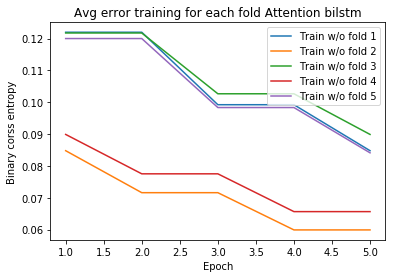

In [7]:
start = 0
end = 5
for i in range(5):
    plt.plot([i for i in range(1,6)], avg_error[start:end], label = 'Train w/o fold {}'.format(i+1))
    start = end
    end +=5
plt.title('Avg error training for each fold Attention bilstm')
plt.legend()
plt.ylabel('Binary corss entropy')
plt.xlabel('Epoch')
plt.show()

In [8]:
with open('results_attn_lstm.txt', mode = 'w') as f: 
    for key in preds.keys():
        f.write(str(key))
        for val in preds[key]:
            f.write(' {}'.format(str(val)))
        f.write('\n')

In [ ]:
predictions = {}
for key in preds.keys(): 
    threshold = 0.6
    temp = []
    for val in preds[key]:
        temp.append(val > threshold)
    temp = sum(temp)
    if temp > 1: 
        predictions[key] = 1
    else:
        predictions[key] = 0
predictions = sorted(predictions.items())

In [ ]:
predictions = [x[1] for x in predictions]
qid = pd.read_csv('data/qid.csv')
sub = {'qid':list(qid.qid), 'prediction':predictions}
submission_ = pd.DataFrame.from_dict(sub)

In [ ]:
actual = pd.read_csv('submission.csv')
flagged = submission_[submission_.prediction == 1]
act_flagged = actual[actual.prediction == 1]
found = 0
for i in act_flagged.index: 
    if submission_.prediction.iloc[i] == 1:
        found += 1
print(found)
print(len(flagged))

In [ ]:
with open('pred_attention_lstm.txt', mode = 'w') as f: 
    f.write('import pandas as pd \n')
    f.write('pred = [')
    count = 0
    written = 0
    #replace data -> pd dataframe
    for ind in submission_.index: 
        if count < 40:
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count += 1
            written += 1
        else: 
            f.write('\n')
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count = 0
            written += 1
    f.write(']\n')
    f.write('test = pd.read_csv(\'../input/test.csv\').qid\n')
    f.write('sub = {\'qid\':[], \'prediction\':[]}\n')

    f.write('for i in range(len(pred)):\n')
    f.write('\tsub[\'qid\'].append(test.iloc[i])\n')
    f.write('\tsub[\'prediction\'].append(pred[i])\n')
    f.write('sub = pd.DataFrame.from_dict(sub)\n')
    f.write('sub.to_csv(\'submission.csv\', index=False)')